Solve the 1-D diffusion equation for the quasiparticle density $n(x, t)$:
$$
\frac{\partial n}{\partial t}
  =
  D \frac{\partial^2 n}{\partial x^2}
  - R_* n^2
  - S(x) n
  + G(x)
  + B,
$$
where $R_*$ is the effective recombination constant, $S(x)$ is the (position-dependent) trapping coefficient, $G(x)$ is the (position-dependent) generation rate, and $B$ is the background generation rate.

In [1]:
from physics.mkid import model

In [44]:
class DiscreteKID(object):
    
    def __init__(self, length, width, thickness, S, G, D, R, B, initial_number=None):
        if initial_number is None:
            initial_number = np.zeros(length.size)
        assert length.size == width.size == thickness.size == S.size == G.size == initial_number.size
        self._previous_number = None
        self.number = [initial_number]
        self.length = length
        self.width = width
        self.thickness = thickness
        self.S = S
        self.G = G
        self.D = D
        self.R = R
        self.B = B
        self.steps = 0
    
    @property
    def x(self):
        return np.cumsum(self.length)
    
    @property
    def volume(self):
        return self.width * self.length * self.thickness
    
    def solve(self, time_step, max_fractional_change=1e-6, max_steps=1000):
        while self.steps < max_steps and not self.converged(max_fractional_change):
            self.number.append(self.number[-1] + time_step * self.volume * self.dn_dt)
            self.steps += 1
    
    def converged(self, max_fractional_change):
        return (len(self.number) > 1 and
                np.max(self.number[-1] / self.number[-2]) < max_fractional_change)

    @property
    def dn_dt(self):
        n = self.number[-1] / self.volume
        return self.D * self.d2_dx2(n) - self.R * n**2 - self.S * n + self.G + self.B
    
    def d2_dx2(self, f):
        y_left = np.concatenate((f, [0, 0]))
        y_here = np.concatenate(([0], f, [0]))
        y_right = np.concatenate(([0, 0], f))
        
    """
    def d2_dx2(self, f):
        y_left = np.concatenate((f, [0, 0]))
        y_here = np.concatenate(([0], f, [0]))
        y_right = np.concatenate(([0, 0], f))
        x_left = np.concatenate((self.x, [np.inf, np.inf]))
        x_here = np.concatenate(([-np.inf], self.x, [np.inf]))
        x_right = np.concatenate(([-np.inf, -np.inf], self.x))
        y = (2 * y_left / ((x_left - x_here) * (x_left - x_right)) +
             2 * y_here / ((x_here - x_left) * (x_here - x_right)) +
             2 * y_right / ((x_right - x_left) * (x_right - x_here)))
        return y[1:-1]
    """

In [45]:
# Values from Glenn
inductor_length_um = 5200
inductor_width_um = 2
thickness_um = 0.04
geometric_inductance = 4e-9
L_g_per_um = geometric_inductance / inductor_length_um  # inductance per unit length, in henries
nominal_volume_um3 = inductor_width_um * inductor_length_um * thickness_um
print("V = {:.0f} um^3".format(nominal_volume_um3))

# Assumed values
T_c = 1.3
T_substrate = 0.3
phonon_trapping_factor = 1
alpha = 0.5
f_r = 1.5e9
iQc = 50e-6
iQi0 = 1e-6
S_TLS_at_P_c = 1e-19
P_c = 1e-13

kid = model.KID(active_metal=model.Aluminum(T_c=T_c),
                active_volume_um3=nominal_volume_um3,
                inactive_metal=None,
                inactive_volume_um3=0,
                substrate=model.Substrate(T=T_substrate),
                phonon_trapping_factor=phonon_trapping_factor,
                alpha=alpha,
                f_r=f_r,
                iQc=iQc,
                iQi0=iQi0,
                S_TLS_at_P_c=S_TLS_at_P_c,
                P_c=P_c)

V = 416 um^3


In [39]:
# Start with square cells
num_cells = int(inductor_length_um / inductor_width_um)
length = inductor_width_um * np.ones(num_cells)
width = inductor_width_um * np.ones(num_cells)
thickness = thickness_um * np.ones(num_cells)
S = np.zeros(num_cells)
G0 = 1e6
G = np.zeros(num_cells)  # np.concatenate((np.zeros(int(num_cells / 2) - 1), [G0, G0], np.zeros(int(num_cells / 2) - 1))) 
B = kid.active_metal.thermal_generation_per_um3(T_substrate)
R = kid.effective_recombination_um3_per_s
D_cm2_per_s = 53  # Ullom, Fisher, and Nahum 1998.
D_um2_per_s = D_cm2_per_s * (10^8)

In [60]:
dk = DiscreteKID(length=length, width=width, thickness=thickness,
                 S=S, G=G, D=D_um2_per_s, R=R, B=B)

In [65]:
dk.solve(time_step=1e-4, max_fractional_change=1e-3, max_steps=1e5)

In [66]:
dk.steps

2

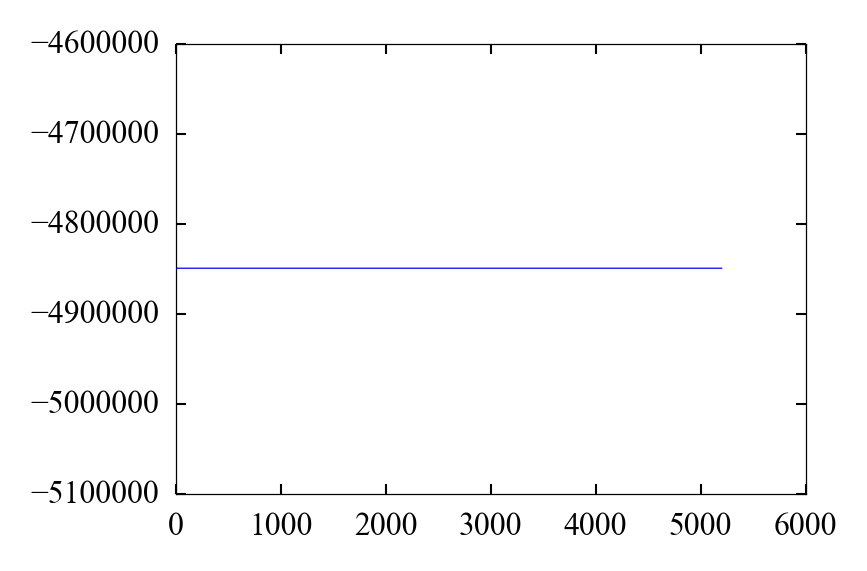

In [67]:
fig, ax = plt.subplots()
ax.plot(dk.x, dk.number[-1], '-')

In [64]:
dk.dn_dt

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:49: RuntimeWarning: invalid value encountered in subtract
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:50: RuntimeWarning: invalid value encountered in subtract


array([ -6.77220773e+15,  -6.77220773e+15,  -6.77220773e+15, ...,
        -6.77220773e+15,  -6.77220773e+15,  -6.77220773e+15])

In [28]:
kid.active_metal.thermal_generation_per_um3(T_substrate) * dk.volume[0]

10278739.789051756

In [29]:
dk.volume[0]

0.16